VanillaGAN是使用普通的DNN结构，但是在处理图像方面CNN具有明显优势，这就是DCGAN(Deep Convolutional GAN)。

In [1]:
import os
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from dataset.dataset import load_mnist

import tensorflow as tf
import numpy as np

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def gen_params():
    return tf.contrib.training.HParams(
        z_size=74,    # 隐变量维度
        conv_size=4,
        filters_g=[64, 1],
        filters_d=[64, 128],
        unit_fc=[1024,7*7*128],
        batch_size=128,
        lr=1e-3,
        img_size=28,    # 图片尺寸
    )


params = gen_params()

train_data, test_data = load_mnist(
    batch_size=params.batch_size)    # 注意MNIST尺寸是28*28


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(60000, 784) (60000,)
(10000, 784) (10000,)


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## 网络设计

In [3]:
unit_I_G = params.z_size    # 生成器输入为隐变量
unit_I_D = train_data.n_features    # 判别器输入为图片

# 卷积层参数定义在params中

unit_O_G = unit_I_D    # 生成器输出为图片
unit_O_D = 1    # 判别器输出为二分类

## 功能函数

In [4]:
def noise_gen(n_samples, z_size):
    '''
    隐变量生成器
    '''
    return np.random.uniform(-1, 1, size=(n_samples, z_size))

## 网络搭建

In [5]:
tf.reset_default_graph()     # 清空图

Z = tf.placeholder(tf.float32, shape=[None, unit_I_G])   # 判别器输入，即隐变量。(None,98)
X = tf.placeholder(tf.float32, shape=[None, unit_I_D])    # 真实图片输入

with tf.name_scope('GAN'):
    def generator(z):
        with tf.variable_scope('Generator'):
            # (None,74) -> (None, 1024)
            dense_1 = tf.layers.dense(z, params.unit_fc[0],
                                      activation=tf.nn.relu)
            dense_1 = tf.layers.batch_normalization(dense_1)

            # (None,1024) -> (None,7*7*128)
            dense_2 = tf.layers.dense(dense_1, params.unit_fc[1],
                                      activation=tf.nn.relu)
            dense_2 = tf.layers.batch_normalization(dense_2)

            # (None,7*7*128) -> (None,7,7,128)
            z_img = tf.reshape(dense_2, [-1, 7, 7, 128])

            # (14,14,64)
            conv_t_1 = tf.layers.conv2d_transpose(z_img,
                                                  filters=params.filters_g[0], kernel_size=params.conv_size,
                                                  strides=2, padding='same', activation=tf.nn.relu)
            conv_t_1 = tf.layers.batch_normalization(conv_t_1)

            # (28,28,1)
            conv_t_2 = tf.layers.conv2d_transpose(conv_t_1,
                                                  filters=params.filters_g[1], kernel_size=params.conv_size,
                                                  strides=2, padding='same', activation=tf.nn.sigmoid)

            img_gen = tf.reshape(conv_t_2, [-1, 784])    # (None, 784)
            return img_gen

    def discriminator(x):
        with tf.variable_scope('Discrimator', reuse=tf.AUTO_REUSE):
            x_img = tf.reshape(x, [-1, 28, 28, 1])

            # (None,14,14,64)
            conv_1 = tf.layers.conv2d(x_img,
                                      filters=params.filters_d[0], kernel_size=params.conv_size,
                                      strides=2, padding='same', activation=tf.nn.leaky_relu)

            # (None,7,7,128)
            conv_2 = tf.layers.conv2d(conv_1, filters=params.filters_d[1], kernel_size=params.conv_size,
                                      strides=2, padding='same', activation=tf.nn.leaky_relu)
            conv_2 = tf.layers.batch_normalization(conv_2)

            # (None,7,7,128) -> (None,1024)
            dense_1 = tf.layers.dense(tf.layers.flatten(conv_2), params.unit_fc[0],
                                      activation=tf.nn.leaky_relu)

            # (None,1)
            logits_D = tf.layers.dense(dense_1, unit_O_D, activation=None)

            return logits_D

    img_fake = generator(Z)    # 生成假图像
    logit_true = discriminator(X)    # 判别器对于真实图像的打分(None, 1)
    logit_false = discriminator(img_fake)    # 判别器对于假图像的打分(None, 1)

    vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope='Generator')
    vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope='Discrimator')

with tf.name_scope('Eval'):
    #     # LSGAN
    #     loss_D=tf.reduce_mean(0.5*tf.square(logit_true-1)+0.5*tf.square(logit_false))
    #     loss_G=tf.reduce_mean(0.5*tf.square(logit_false-1))

    #     # GAN
    #     loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    #         logits=logit_true,
    #         labels=tf.ones_like(logit_true)) +
    #         tf.nn.sigmoid_cross_entropy_with_logits(
    #             logits=logit_false,
    #             labels=tf.zeros_like(logit_false)))
    #     loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    #         logits=logit_false,
    #         labels=tf.ones_like(logit_false)))

    # WGAN
    n_batch = tf.placeholder(tf.int32, ())    # 实际传入batch_size的大小
    loss_D = -(tf.reduce_mean(logit_true)-tf.reduce_mean(logit_false))
    loss_G = -tf.reduce_mean(logit_false)
    lam = 10

    eps = tf.random_uniform(shape=[n_batch, 1], minval=0, maxval=1)
    x_hat = X*eps+(1-eps)*img_fake

    with tf.variable_scope('', reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat)
    grad_pen = lam*tf.square(grad_norm-1)
    loss_D += grad_pen


with tf.name_scope('train_op'):
    train_op_G = tf.train.AdamOptimizer(params.lr) \
        .minimize(loss_G, var_list=vars_G)
    train_op_D = tf.train.AdamOptimizer(params.lr) \
        .minimize(loss_D, var_list=vars_D)


def get_sess():
    init = tf.global_variables_initializer()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True    # 按需使用显存
    sess = tf.Session(config=config)
    sess.run(init)
    return sess

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.


## 训练网络

In [6]:
sess = get_sess()
epochs = 20

batch_cnt = 0

for epoch in range(epochs):
    for batch_data, _ in train_data.next_batch():
        batch_cnt += 1

        img_gen, loss_val_G, _ = sess.run([img_fake, loss_G, train_op_G],
                                          feed_dict={Z: noise_gen(len(batch_data), unit_I_G),
                                                     n_batch: len(batch_data)})

        loss_val_D, _ = sess.run([loss_D, train_op_D],
                                 feed_dict={X: batch_data,
                                            Z: noise_gen(len(batch_data), unit_I_G),
                                            n_batch: len(batch_data)})

        # 每1000batch输出一次信息
        if (batch_cnt+1) % 1000 == 0:
            print('epoch: {}, batch_loss_D: {}, batch_loss_G: {}'
                  .format(epoch+1, loss_val_D, loss_val_G))

epoch: 3, batch_loss_D: -0.3086276650428772, batch_loss_G: 0.549034595489502
epoch: 5, batch_loss_D: -0.25366201996803284, batch_loss_G: 0.747999370098114
epoch: 7, batch_loss_D: -0.07083472609519958, batch_loss_G: 0.45459920167922974
epoch: 9, batch_loss_D: -0.09367817640304565, batch_loss_G: -2.914853572845459
epoch: 11, batch_loss_D: 0.03448810055851936, batch_loss_G: 3.740757703781128
epoch: 13, batch_loss_D: 0.013397288508713245, batch_loss_G: 0.9908500909805298
epoch: 15, batch_loss_D: -0.05217839032411575, batch_loss_G: 0.3781539797782898
epoch: 18, batch_loss_D: -0.020503949373960495, batch_loss_G: 1.4878742694854736
epoch: 20, batch_loss_D: -0.08793406188488007, batch_loss_G: -0.9399019479751587


<Figure size 432x288 with 0 Axes>

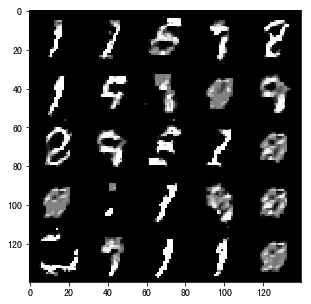

In [11]:
# 生成不同范围的二维输入，生成图片
import matplotlib.pyplot as plt
n = 5
x_axis = np.linspace(-1, 1, n)
y_axis = np.linspace(-1, 1, n)
canvas = np.empty((28 * n, 28 * n))    # 画布，不同区域填充不同的图片

for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        x_mean = sess.run(img_fake, feed_dict={Z: noise_gen(1, unit_I_G)})
        canvas[(n - i - 1) * 28:(n - i) * 28, j *
               28:(j + 1) * 28] = x_mean[0].reshape(28, 28)


plt.clf()
plt.figure(figsize=(5, 5))
plt.imshow(canvas, cmap='gray')
plt.show()